In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asl-dataset/sign_dataset/N/2021-07-25_21-50-45.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2021-07-25_21-55-04.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2021-07-25_21-51-37.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2021-07-25_21-51-15.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2022-08-25_14-56-31.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2021-07-25_21-54-00.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2021-07-25_21-52-38.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2021-07-25_21-53-31.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2021-07-25_21-51-24.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2021-07-25_21-49-45.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2022-08-25_14-57-16.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2021-07-25_21-46-30.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2021-07-25_21-55-00.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2021-07-25_21-53-23.jpg
/kaggle/input/asl-dataset/sign_dataset/N/2021-07-25_21-53-16.jpg
/kaggle/input/asl-dataset

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm


In [9]:
path = "/kaggle/input/asl-dataset/sign_dataset"
files = os.listdir(path)
#sort in order a to y
files.sort()
print(files)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [10]:
#list of images and label 

image_array =[]
label_array =[]
#loop through each file in files

for i in tqdm(range(len(files))):
    #list of images address 
    sub_file= os.listdir(path+"/"+files[i])
    #length of images for each class
    #print(len(sub_file))
    
    for j in range(len(sub_file)): #iterate thru each image 
        #path of each image
        file_path = path+"/"+files[i]+"/"+sub_file[j]
        
        #read each image thru open cv
        image = cv2.imread(file_path)
        
        #resize to 96x96
        image = cv2.resize(image,(96,96))
        
        #BGR TO RGB
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        #add to array
        image_array.append(image)
        #
        label_array.append(i)


100%|██████████| 25/25 [01:16<00:00,  3.06s/it]


In [11]:
image_array = np.array(image_array)
label_array = np.array(label_array,dtype="float")

In [12]:
#Split 85:15

from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(image_array,label_array,test_size=0.15)

del image_array,label_array

In [13]:
#model

from keras import layers,callbacks,utils,applications,optimizers
from keras.models import Sequential, Model, load_model

model = Sequential()

pretrained_model = tf.keras.applications.EfficientNetB0(input_shape=(96,96,3),include_top = False)
model.add(pretrained_model)

#avg_pooling
model.add(layers.GlobalAveragePooling2D())

#droput to min overfitting
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1))
model.build(input_shape=(None,96,96,3))

model.summary()

2022-08-26 17:21:41.864050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 17:21:42.022691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 17:21:42.023558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 17:21:42.025028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16719872/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 3, 3, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________


In [14]:
#compile model

model.compile(optimizer="adam",loss="mae",metrics=["mae"])

check_path ="trained_model/model"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = check_path,
                                                     monitor="val_mae",
                                                    mode="auto",
                                                     save_best_only=True,
                                                     save_weights_only=True
                                                     )

#reduce lr when accuracy does not improve
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.9,
                                        monitor="val_mae",
                                        mode="auto",
                                        cooldown=0,
                                        patience=5,
                                        verbose=1,
                                        min_lr=1e-6)
#0.9x reduced lr
Epochs = 100
Batch_Size= 32



In [15]:
#TRAIN
history = model.fit(X_train,Y_train,validation_data=(X_test,Y_test),
                   batch_size=Batch_Size,
                   epochs=Epochs,
                   callbacks=[model_checkpoint,reduce_lr])

2022-08-26 17:21:48.128174: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-08-26 17:21:56.457566: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


367/367 [==============================] - 42s 73ms/step - loss: 2.9826 - mae: 2.9826 - val_loss: 2.1273 - val_mae: 2.1273
Epoch 2/100
367/367 [==============================] - 25s 68ms/step - loss: 1.2798 - mae: 1.2798 - val_loss: 1.4765 - val_mae: 1.4765
Epoch 3/100
367/367 [==============================] - 25s 69ms/step - loss: 0.9485 - mae: 0.9485 - val_loss: 1.7549 - val_mae: 1.7549
Epoch 4/100
367/367 [==============================] - 25s 68ms/step - loss: 0.7476 - mae: 0.7476 - val_loss: 0.8464 - val_mae: 0.8464
Epoch 5/100
367/367 [==============================] - 25s 68ms/step - loss: 0.6615 - mae: 0.6615 - val_loss: 0.4779 - val_mae: 0.4779
Epoch 6/100
367/367 [==============================] - 25s 68ms/step - loss: 0.6669 - mae: 0.6669 - val_loss: 0.4356 - val_mae: 0.4356
Epoch 7/100
367/367 [==============================] - 25s 68ms/step - loss: 0.5332 - mae: 0.5332 - val_loss: 0.4753 - val_mae: 0.4753
Epoch 8/100
367/367 [==============================] - 25s 69ms/ste

In [16]:
model.load_weights(check_path)

# convert model to tensorflow lite model

converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

# save model
with open("model.tflite","wb") as f:
    f.write(tflite_model)

2022-08-26 18:04:31.200475: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-08-26 18:04:56.416106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 18:04:56.416544: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-08-26 18:04:56.416675: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-08-26 18:04:56.417239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.

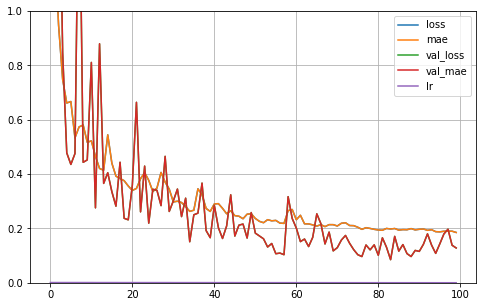

In [17]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()